## Homework 4

Use this notebook as a starter

In [197]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [198]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [199]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [200]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [201]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [202]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [203]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [204]:
categorical = list(df.dtypes[df.dtypes == object].index)
numerical = list(df.dtypes[df.dtypes == 'int64'].index)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [205]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [206]:
len(df_train), len(df_val), len(df_test), len(df_full_train), len(df)

(2672, 891, 891, 3563, 4454)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [207]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [208]:
for feature in ['seniority','time','income', 'debt']:
    print(f'{feature}: {roc_auc_score(df_train.default, df_train[feature])}')

seniority: 0.2906221375508058
time: 0.5608662489595051
income: 0.31799333386736695
debt: 0.49521703242164505


In [211]:
print(f'Seniority: {roc_auc_score(df_train.default, -df_train["seniority"])}')
print(f'Time: {roc_auc_score(df_train.default, df_train["time"])}')
print(f'Income: {roc_auc_score(df_train.default, -df_train["income"])}')
print(f'Debt: {roc_auc_score(df_train.default, -df_train["debt"])}')

Seniority: 0.7093778624491943
Time: 0.5608662489595051
Income: 0.682006666132633
Debt: 0.5047829675783548


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [157]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [158]:
y_train = df_train.default
y_val = df_val.default
y_test = df_test.default
y_full_train = df_full_train.default


df_train = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
df_val = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home']]
df_test = df_test[['seniority', 'income', 'assets', 'records', 'job', 'home']]
df_full_train = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]

In [159]:
dv = DictVectorizer(sparse = False)
train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [160]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [161]:
y_preds = model.predict_proba(X_val)

In [162]:
y_preds

array([[0.81469175, 0.18530825],
       [0.87771952, 0.12228048],
       [0.71003566, 0.28996434],
       ...,
       [0.4920945 , 0.5079055 ],
       [0.56209457, 0.43790543],
       [0.50683844, 0.49316156]])

In [163]:
print(f'Accuracy: {((y_preds[:,1] > 0.5).astype(int) == y_val).mean()}')

Accuracy: 0.7777777777777778


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [164]:
roc_auc_score(y_val, y_preds[:,1]).round(3)

0.811

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [165]:
thresholds = np.linspace(0, 1, num = 101)
precisions = []
recalls = []
for threshold in thresholds:
    y_pred = (y_preds[:,1] >= threshold).astype(int)
    tp = ((y_val == 1).to_numpy() & (y_pred == 1)).sum()
    fp = ((y_val == 0).to_numpy() & (y_pred == 1)).sum()
    tn = ((y_val == 0).to_numpy() & (y_pred == 0)).sum()
    fn = ((y_val == 1).to_numpy() & (y_pred == 0)).sum()
    precision = tp / (tp + fp)
    precisions.append(precision)
    recall = tp / (tp + fn)
    recalls.append(recall)

/tmp/ipykernel_2838635/842743439.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [166]:
precisions[::10], recalls[::10]

([0.2760942760942761,
  0.34558823529411764,
  0.43724696356275305,
  0.520891364902507,
  0.578125,
  0.6363636363636364,
  0.6724137931034483,
  0.7413793103448276,
  0.7857142857142857,
  0.75,
  nan],
 [1.0,
  0.9552845528455285,
  0.8780487804878049,
  0.7601626016260162,
  0.6016260162601627,
  0.45528455284552843,
  0.3170731707317073,
  0.17479674796747968,
  0.08943089430894309,
  0.024390243902439025,
  0.0])

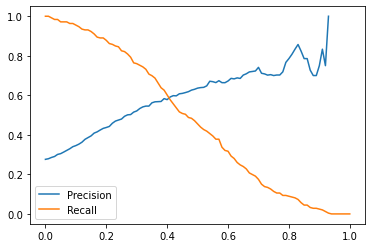

In [167]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [168]:
F1 = 2 * np.array(precisions) * np.array(recalls) / (np.array(precisions) + np.array(recalls))

In [169]:
F1 = F1[~np.isnan(F1)]
thresholds[F1.argmax()]

0.32

In [170]:
F1[10], F1[30], F1[50], F1[70]

(0.5075593952483801,
 0.6181818181818182,
 0.5308056872037915,
 0.28289473684210525)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [175]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
from tqdm.auto import tqdm

In [183]:
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
#     breakpoint()
    df_train = df_full_train.iloc[train_idx]
    y_train = y_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_val = y_full_train.iloc[val_idx]
#     breakpoint()
    dv = DictVectorizer(sparse = False)
    train_dict = df_train.to_dict(orient = 'records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val.to_dict(orient = 'records')
    X_val = dv.transform(val_dict)
    
    model.fit(X_train, y_train)
    y_preds = model.predict_proba(X_val)[:,1]
    AUC = roc_auc_score(y_val, y_preds)
    scores.append(AUC)
print(scores)
    

0it [00:00, ?it/s]

[0.8256212256212256, 0.8254077031563476, 0.7893383818254285, 0.8250108084738436, 0.8054696294614563]


In [185]:
np.std(scores)

0.01460989648482707

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [190]:
C_values = [0.01, 0.1, 1, 10]
results = []
for C in C_values: 
    scores = []
    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    #     breakpoint()
        df_train = df_full_train.iloc[train_idx]
        y_train = y_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_val = y_full_train.iloc[val_idx]
    #     breakpoint()
        dv = DictVectorizer(sparse = False)
        train_dict = df_train.to_dict(orient = 'records')
        X_train = dv.fit_transform(train_dict)
        val_dict = df_val.to_dict(orient = 'records')
        X_val = dv.transform(val_dict)

        model.fit(X_train, y_train)
        y_preds = model.predict_proba(X_val)[:,1]
        AUC = roc_auc_score(y_val, y_preds)
        scores.append(AUC)
    results.append((np.mean(scores).round(3), np.std(scores).round(3)))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [191]:
results

[(0.809, 0.013), (0.813, 0.014), (0.814, 0.015), (0.812, 0.014)]

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.